# 📊 03 - Modelagem

## 0. Configuração Inicial

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
sys.path.append(os.path.abspath('../models'))

import pandas as pd
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from isolation_forest import isoforest
from local_outlier_factor import lof

Carregando os dados de treino e teste novamente

In [2]:
x_train = pd.read_csv('../data/processed/creditcard_train.csv')
x_test = pd.read_csv('../data/processed/creditcard_test.csv')
y_test = pd.read_csv('../data/processed/creditcard_test_label.csv')

print(f"Treino carregado: {x_train.shape}")
print(f"Teste carregado: {x_test.shape}")

Treino carregado: (226602, 30)
Teste carregado: (57124, 30)


In [3]:
def plot_confusion_matrix(y_pred, title):
    cm = confusion_matrix(y_test.iloc[:, 0], y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(label=title)
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()

## 1. Isolation Forest

In [20]:
iso_forest, y_pred = isoforest(x_train, x_test, 100, 'auto', 'auto')


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     56651
      Fraude       0.16      0.83      0.26       473

    accuracy                           0.96     57124
   macro avg       0.58      0.90      0.62     57124
weighted avg       0.99      0.96      0.97     57124



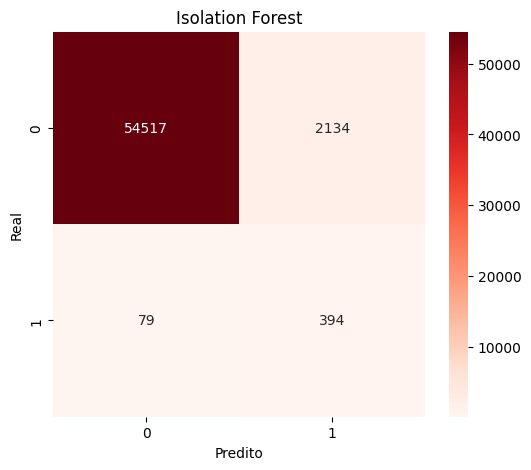

In [21]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Isolation Forest")

## 2. Local Outlier Factor (Lof)

In [ ]:
lof, y_pred = lof(x_train, x_test, 100, 'minkowski', 'auto')


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     56651
      Fraude       0.15      0.84      0.26       473

    accuracy                           0.96     57124
   macro avg       0.58      0.90      0.62     57124
weighted avg       0.99      0.96      0.97     57124



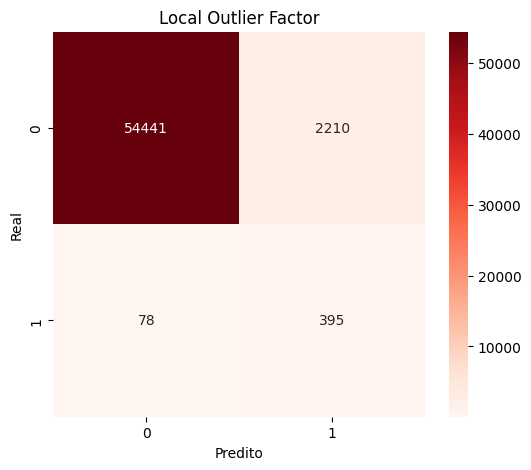

In [23]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Local Outlier Factor")

## 3. Autoencoders

## 4. Tunagem

### Isolation Forest

In [4]:
def objective(trial):
    # n_estimators: Quantas árvores na floresta
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    # max_samples: Quantas amostras usar para treinar cada árvore
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    
    # contamination: A proporção esperada de outliers no dataset.
    contamination = trial.suggest_float('contamination', 0.0001, 0.02)

    iso_forest, y_pred = isoforest(x_train, x_test, n_estimators, contamination, max_samples)

    # Avaliação com AUPRC (Area Under Precision-Recall Curve)
    auprc = average_precision_score(y_test, y_pred)

    return auprc

In [5]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-12-14 18:18:14,820] A new study created in memory with name: no-name-667c05f6-a8fd-4550-b57b-309f56e06faa
[I 2025-12-14 18:18:25,793] Trial 0 finished with value: 0.24879580435127657 and parameters: {'n_estimators': 276, 'max_samples': 0.15811238936475905, 'contamination': 0.0013070498423202964}. Best is trial 0 with value: 0.24879580435127657.
[I 2025-12-14 18:18:40,001] Trial 1 finished with value: 0.2726891588945851 and parameters: {'n_estimators': 264, 'max_samples': 0.47694108837952165, 'contamination': 0.013118834200235002}. Best is trial 1 with value: 0.2726891588945851.
[I 2025-12-14 18:18:45,123] Trial 2 finished with value: 0.3442354590615806 and parameters: {'n_estimators': 99, 'max_samples': 0.31493308025806543, 'contamination': 0.005369085438307235}. Best is trial 2 with value: 0.3442354590615806.
[I 2025-12-14 18:18:54,421] Trial 3 finished with value: 0.2505901197882037 and parameters: {'n_estimators': 174, 'max_samples': 0.4347834827022544, 'contamination': 0.01

In [6]:
print("------------------------------------------------")
print("Melhores parâmetros encontrados:")
print(study.best_params)
print(f"Melhor AUPRC: {study.best_value:.4f}")

------------------------------------------------
Melhores parâmetros encontrados:
{'n_estimators': 121, 'max_samples': 0.8556100570996847, 'contamination': 0.002317817171612695}
Melhor AUPRC: 0.4077


Estatisticas do melhor modelo

In [7]:
best_model_if = IsolationForest(**study.best_params, random_state=42, n_jobs=-1)
best_model_if.fit(x_train)

y_pred_raw = best_model_if.predict(x_test)
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
      Fraude       0.70      0.58      0.63       473

    accuracy                           0.99     57124
   macro avg       0.85      0.79      0.81     57124
weighted avg       0.99      0.99      0.99     57124



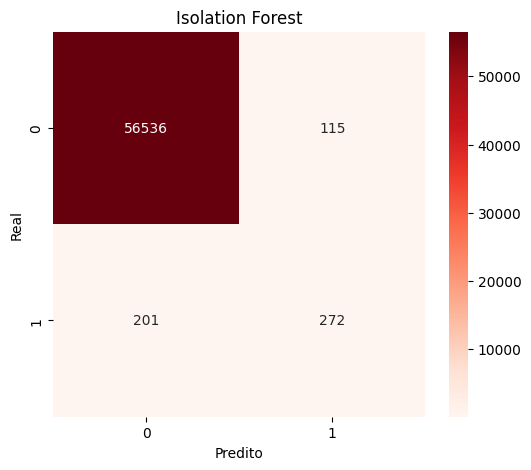

In [8]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Isolation Forest")

### Local Outlier Factor

In [ ]:
def objective(trial):  
    n_neighbors = trial.suggest_int('n_neighbors', 10, 100)
    
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    
    # contamination: Define o limiar de decisão
    contamination = trial.suggest_float('contamination', 0.0001, 0.02)

    model, y_pred = lof(x_train, x_test, n_neighbors, metric, contamination)

    # Avaliação com AUPRC (Area Under Precision-Recall Curve)
    auprc = average_precision_score(y_test, y_pred)

    return auprc

In [5]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=1800)

[I 2025-12-14 17:42:56,198] A new study created in memory with name: no-name-cd5457c9-82b8-47d2-992c-3b9f8a189372
[I 2025-12-14 17:43:58,169] Trial 0 finished with value: 0.04438435519887753 and parameters: {'n_neighbors': 36, 'metric': 'minkowski', 'contamination': 0.017388550758329915}. Best is trial 0 with value: 0.04438435519887753.
[I 2025-12-14 17:44:55,962] Trial 1 finished with value: 0.02134853577848333 and parameters: {'n_neighbors': 23, 'metric': 'minkowski', 'contamination': 0.013440873149502179}. Best is trial 0 with value: 0.04438435519887753.
[I 2025-12-14 17:49:02,143] Trial 2 finished with value: 0.014669210505115424 and parameters: {'n_neighbors': 88, 'metric': 'manhattan', 'contamination': 0.0006446902069446967}. Best is trial 0 with value: 0.04438435519887753.
[I 2025-12-14 17:49:59,442] Trial 3 finished with value: 0.023381758135820628 and parameters: {'n_neighbors': 24, 'metric': 'euclidean', 'contamination': 0.01799066901416926}. Best is trial 0 with value: 0.044

In [6]:
print("------------------------------------------------")
print("Melhores parâmetros:")
print(study.best_params)
print(f"Melhor AUPRC: {study.best_value:.4f}")

------------------------------------------------
Melhores parâmetros:
{'n_neighbors': 82, 'metric': 'euclidean', 'contamination': 0.002635876522946787}
Melhor AUPRC: 0.4120


Estatisticas do melhor modelo

In [9]:
best_model_lof = LocalOutlierFactor(**study.best_params, novelty=True, n_jobs=-1)
best_model_lof.fit(x_train)

y_pred_raw = best_model_lof.predict(x_test)
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]


          --- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56651
      Fraude       0.66      0.62      0.64       473

    accuracy                           0.99     57124
   macro avg       0.83      0.81      0.82     57124
weighted avg       0.99      0.99      0.99     57124



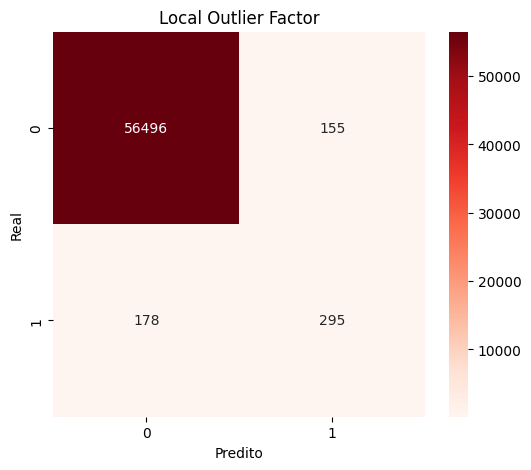

In [11]:
print("\n          --- Relatório de Classificação ---")
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

plot_confusion_matrix(y_pred, "Local Outlier Factor")

### Autoencoders

## 5. Comparação de Resultados